In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import sys
import os

import grid2op
from grid2op.PlotGrid import PlotMatplot
from grid2op.Parameters import Parameters

Given the reward and topology configuration tables we computed previously, we will now build our Trnsition Graph over a scenario, an edge corresponding to an allowed transition weighted by the reward of the topology configuration reached.

Based on this, we compute the best action path with Graph algorithms and extract the best topologies over the scenario. We eventually compare it to some baselines we can simply derive here


## Config


In [2]:
path_data = os.path.join('.')

Depending if we have a reward that needs to be minimized of maximized, we will try to find the shortest path or longest path

In [4]:
# If True -> algo:
# Else - > algo: dag_longest_path

find_shortest_path = False

## Load the Score Table for all configurations

In [5]:
dataset_csv = os.path.join(path_data, 'rewards.csv')

# Read CSV
rewards = pd.read_csv(dataset_csv, index_col=0)

# # Change sign to find shortest path
# rewards_neg = rewards.iloc[:, 1:].applymap(lambda x: x * -1)
# rewards.drop(rewards.iloc[:, 1:], axis='columns', inplace=True)
# rewards = pd.concat([rewards, rewards_neg], axis='columns')

In [6]:
ncolumns=rewards.shape[1]
rewards.head()

,scenario,rewards_135,rewards_307,rewards_61,rewards_95,rewards_338,rewards_300,rewards_132,rewards_59,rewards_92,...,rewards_14,rewards_182,rewards_344,rewards_176,rewards_22,rewards_149,rewards_171,rewards_343,rewards_185,rewards_388
0,0,15.544678,15.334645,0.0,15.923058,13.295711,0.0,12.553727,16.067440,12.657386,...,13.175545,10.083261,13.141179,13.198183,13.868277,15.273135,15.583221,15.420814,13.996116,13.320590
1,0,15.529463,15.279513,0.0,15.876092,13.206120,0.0,12.506397,16.032618,12.614249,...,13.159655,10.355207,13.050347,13.128224,13.808628,15.319910,15.530590,15.360577,14.085559,13.312389
2,0,15.558784,15.340264,0.0,15.933270,13.308941,0.0,12.613354,16.060616,12.794056,...,13.197915,10.271022,13.170179,13.246445,13.875764,15.294630,15.575570,15.432715,14.048141,13.339405
3,0,15.586547,15.371600,0.0,15.945747,13.323692,0.0,12.608726,16.094797,12.755759,...,13.236300,10.309238,13.175028,13.268039,13.905323,15.359059,15.599242,15.462725,14.074714,13.393047
4,0,15.628961,15.413688,0.0,15.986158,13.379869,0.0,12.638037,16.128023,12.821815,...,13.291741,10.312976,13.239091,13.328225,13.950562,15.424251,15.630280,15.502772,14.122160,13.453857


In [7]:
ncolumns

473

In [8]:
rewardActionColumns=rewards.columns[1:ncolumns]

In [9]:
#plot=rewards.iloc[:,2:ncolumns].sum().plot.bar()

<AxesSubplot:ylabel='Frequency'>

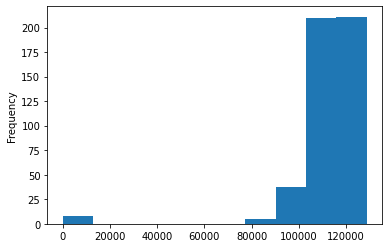

In [10]:
#plot the cumulated score for every configuration
rewards[rewardActionColumns].sum().plot.hist()

## Reorder Reward DataFrame columns
All configurations did not converge during the computations: only about 2200 over 8500. 
Also they were computed in parallel so they are not ordered by their ID. That's what we do in the following.

In [11]:
#columnNames = rewards.columns[1:]
columnIndexes = [int(str.split(name,'_')[1]) for name in rewardActionColumns]

iDXOrder = np.argsort(columnIndexes)
newColumnNames = rewardActionColumns[iDXOrder]
newColumnNames = ['scenario'] + list(newColumnNames)#['time', 'scenario'] + list(newColumnNames)

In [12]:
rewards = rewards[newColumnNames]
rewards.head()

,scenario,rewards_0,rewards_1,rewards_2,rewards_3,rewards_4,rewards_5,rewards_6,rewards_7,rewards_8,...,rewards_470,rewards_471,rewards_472,rewards_473,rewards_474,rewards_475,rewards_476,rewards_477,rewards_478,rewards_479
0,0,13.585202,15.085920,13.216297,16.015745,13.836801,16.054813,13.495529,15.242069,13.346648,...,12.924536,15.341103,13.296644,15.508126,13.053494,15.304689,12.973577,15.384789,13.336229,15.579040
1,0,13.521549,15.067727,12.943394,15.870079,13.801832,16.064592,13.435523,15.205590,13.261583,...,12.881255,15.311994,13.257560,15.485546,12.984688,15.250122,12.904151,15.328445,13.270094,15.527908
2,0,13.592221,15.119214,13.216393,16.016151,13.850277,16.065239,13.503464,15.267128,13.382435,...,12.953221,15.360677,13.306840,15.510641,13.067960,15.316857,13.001523,15.404315,13.344214,15.579704
3,0,13.601656,15.109522,13.198355,16.016758,13.882584,16.101461,13.515002,15.255240,13.384030,...,12.972646,15.377178,13.343680,15.545803,13.101622,15.348693,13.010860,15.410340,13.371042,15.604175
4,0,13.625154,15.160879,13.201025,16.034550,13.936505,16.152891,13.538668,15.306983,13.447144,...,13.035012,15.425595,13.391235,15.582893,13.149178,15.387849,13.074343,15.461219,13.420604,15.643925


In [13]:
sumRewardsConfig = rewards[rewardActionColumns].sum()
#idxHighRewards = np.where(sumRewardsConfig >= 80000)
idxLowRewards = np.where(sumRewardsConfig <= 380000)
rewardActionColumns[idxLowRewards]

Index(['rewards_135', 'rewards_307', 'rewards_61', 'rewards_95', 'rewards_338',
       'rewards_300', 'rewards_132', 'rewards_59', 'rewards_92', 'rewards_66',
       ...
       'rewards_14', 'rewards_182', 'rewards_344', 'rewards_176', 'rewards_22',
       'rewards_149', 'rewards_171', 'rewards_343', 'rewards_185',
       'rewards_388'],
      dtype='object', length=472)

In [14]:
#unique, counts = np.unique(rewards.iloc[:, 2:ncolumns].idxmax(axis=1), return_counts=True)
unique, counts = np.unique(rewards[rewardActionColumns].idxmin(axis=1), return_counts=True)

In [15]:
print('here are the configurations which performed best at least once in the scenarios')
unique, counts 

here are the configurations which performed best at least once in the scenarios


(array(['rewards_61'], dtype=object), array([8064]))

## Histogram of times a configuration performed best

In [16]:
# rewards[rewardActionColumns].idxmin(axis=1).hist(bins=10)#value_counts().plot(kind='hist')

In [17]:
#sumRewardsMAx = rewards.iloc[:,2:ncolumns].max(axis=1).sum()
sumRewardsMin = rewards[rewardActionColumns].min(axis=1).sum()

In [18]:
#print("maximum possible reward over scenarios if you pick up the best configuration at each time, meaning you can play any action at each timestep")
#sumRewardsMAx
print("minimum possible reward over scenarios if you pick up the best configuration at each time, meaning you can play any action at each timestep")
sumRewardsMin

minimum possible reward over scenarios if you pick up the best configuration at each time, meaning you can play any action at each timestep


0.0

In [19]:
#get the indices of the best configurations
#iDXBest = np.argsort(-np.array(sumRewardsConfig))[0:50]
iDXBest = np.argsort(np.array(sumRewardsConfig))[0:50]
iDXBest

array([  2,   5,  52, 216, 162,  45, 314, 337, 304, 463, 257,  83, 226,
        99, 262, 420,  71, 376, 447, 399, 359, 195, 330, 369, 260,  59,
        23, 123, 229, 414, 111, 113, 112, 394,  30,  91, 134, 196,  57,
       334, 289, 135, 311, 454, 442,   6, 192, 431, 306, 380])

# Load Table of Configuration description

In [20]:
actions_csv = os.path.join(path_data, "states_table.csv")

actionsRelevantWithIndex = pd.read_csv(actions_csv, index_col=0)
actionsRelevant = actionsRelevantWithIndex.reset_index(drop=True)

# .reset_index(drop=True)
actionsRelevant.head()

,sub_0,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6,sub_7,sub_8,sub_9,...,8_9_10,8_13_11,9_10_12,11_12_13,12_13_14,3_6_15,3_8_16,4_5_17,6_7_18,6_8_19
0,"[0, 0, 0]","[1, 0, 1, 1, 0, 0]","[0, 0, 0, 0]","[0, 0, 1, 0, 1, 0]","[0, 1, 1, 0, 0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0]","[0, 0]","[0, 1, 1, 0, 0]","[0, 0, 0]",...,0,0,0,0,0,0,0,0,0,0
1,"[0, 0, 0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0, 1, 0]","[1, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0]","[0, 0]","[1, 1, 0, 1, 0]","[0, 0, 0]",...,0,0,0,0,0,0,0,0,0,0
2,"[0, 0, 0]","[1, 0, 1, 1, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0, 1, 0]","[0, 1, 0, 0, 1]","[0, 0, 0, 0, 0, 0]","[0, 0, 0]","[0, 0]","[1, 1, 0, 1, 0]","[0, 0, 0]",...,0,0,0,0,0,0,0,0,0,0
3,"[0, 0, 0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 1, 0, 1, 0]","[0, 1, 0, 0, 1]","[0, 0, 0, 0, 0, 0]","[0, 0, 0]","[0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0]",...,0,0,0,0,0,0,0,0,0,0
4,"[0, 0, 0]","[1, 0, 0, 1, 0, 1]","[0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[1, 0, 0, 1, 0]","[1, 0, 1, 1, 0, 0]","[0, 0, 0]","[0, 0]","[0, 1, 1, 0, 0]","[0, 0, 0]",...,0,0,0,0,0,0,0,0,0,0


In [21]:
actionsRelevant.shape

(472, 34)

# Get Authorized Transitions
Since you are only allowed one action to switch to a new configuration, this limits the configuration you can reach and transition to, from one timestep to another.
Tha's this transition matrix we compute here

In [22]:
vectorReachableTopologies=[ [i] for i in range(actionsRelevant.shape[0]) ]

In [23]:
colmumnNames=np.array(actionsRelevant.columns)
#dfObj.duplicated(['Age', 'City'])

To find the configurations one action away at most from a given configuration, you delete one action column in the action table and you find the similar rows. Then you loop over all columns.

In [24]:
#on cherche les configurations qui sont a au plus une action de distance

for i in range(len(colmumnNames)):
    newCols=np.delete(colmumnNames,i)
    df=actionsRelevant[newCols]
    df = df[df.duplicated(keep=False)]
    df = np.array(df.groupby(df.columns.tolist()).apply(lambda x: tuple(x.index)))
    #print (df)

    for i in range(df.shape[0]):
        indices=np.array(df[i])
        for j in indices:
            #vectorReachableTopologies[j]=vectorReachableTopologies[j]+indices
            vectorReachableTopologies[j]=np.concatenate((vectorReachableTopologies[j], indices))

In [25]:
vectorReachableTopologies=[np.unique(vectorReachableTopologies[j]) for j in range(len(vectorReachableTopologies))]

In [26]:
vectorReachableTopologies

[array([  0,  25,  44,  49, 182, 299, 353, 363, 391, 407, 420, 423, 427,
        453]),
 array([  1,  12,  16,  45,  46,  48,  61,  90, 125, 128, 165, 313, 343,
        406]),
 array([  2,  45,  46,  52, 216, 259, 264, 278, 298, 303, 314, 435, 441,
        457]),
 array([  3,  47,  50, 137, 184, 225, 258, 269, 324, 404, 405, 422, 436,
        448]),
 array([  4,  10,  51,  78,  91, 123, 210, 229, 250, 270, 277, 352, 387,
        464]),
 array([  5,  45,  48,  52, 105, 138, 162, 175, 186, 260, 304, 337, 338,
        394]),
 array([  6,  44,  49,  67, 104, 135, 162, 197, 228, 261, 271, 394, 432,
        460]),
 array([  7,  17,  31,  43, 174, 259, 268, 272, 298, 308, 395, 404, 433,
        436]),
 array([  8,  14,  47,  50, 134, 164, 185, 195, 196, 226, 230, 265, 307,
        323]),
 array([  9,  14,  46,  48,  52, 166, 183, 212, 267, 307, 310, 408, 409,
        446]),
 array([  4,  10,  28,  40,  70, 105, 175, 198, 210, 263, 334, 360, 415]),
 array([ 11,  26,  36,  38,  39, 133, 185, 19

In [ ]:
TO DO: We should also consider possible gameovers that could have occured, if we use another reward

# Look at max rewards

In [41]:
# ScenarioStudied='december_12'
ScenarioStudied=0

In [42]:
rewards.scenario.unique()

array([0])

In [43]:
rewards_scenario=rewards.loc[rewards['scenario']==ScenarioStudied]

In [44]:
rewards_scenario

,scenario,rewards_0,rewards_1,rewards_2,rewards_3,rewards_4,rewards_5,rewards_6,rewards_7,rewards_8,...,rewards_470,rewards_471,rewards_472,rewards_473,rewards_474,rewards_475,rewards_476,rewards_477,rewards_478,rewards_479
0,0,13.585202,15.085920,13.216297,16.015745,13.836801,16.054813,13.495529,15.242069,13.346648,...,12.924536,15.341103,13.296644,15.508126,13.053494,15.304689,12.973577,15.384789,13.336229,15.579040
1,0,13.521549,15.067727,12.943394,15.870079,13.801832,16.064592,13.435523,15.205590,13.261583,...,12.881255,15.311994,13.257560,15.485546,12.984688,15.250122,12.904151,15.328445,13.270094,15.527908
2,0,13.592221,15.119214,13.216393,16.016151,13.850277,16.065239,13.503464,15.267128,13.382435,...,12.953221,15.360677,13.306840,15.510641,13.067960,15.316857,13.001523,15.404315,13.344214,15.579704
3,0,13.601656,15.109522,13.198355,16.016758,13.882584,16.101461,13.515002,15.255240,13.384030,...,12.972646,15.377178,13.343680,15.545803,13.101622,15.348693,13.010860,15.410340,13.371042,15.604175
4,0,13.625154,15.160879,13.201025,16.034550,13.936505,16.152891,13.538668,15.306983,13.447144,...,13.035012,15.425595,13.391235,15.582893,13.149178,15.387849,13.074343,15.461219,13.420604,15.643925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8059,0,13.068567,15.099433,12.264484,14.962460,13.632324,15.968330,13.063009,15.102743,13.165279,...,12.551654,14.990685,12.898204,15.125064,12.654277,14.953217,12.624617,15.068079,12.959745,15.234726
8060,0,13.064602,15.137712,12.123240,14.602899,13.584313,15.971840,13.043613,15.111359,13.125840,...,12.543752,14.995227,12.890193,15.133422,12.635022,14.949154,12.604002,15.058408,12.938354,15.227578
8061,0,13.219513,14.937728,12.807573,15.715505,13.690025,15.939266,13.142579,15.111089,13.274150,...,12.557449,14.996784,12.903257,15.131791,12.710404,15.020299,12.688104,15.133491,13.023368,15.302809
8062,0,13.106826,15.020693,12.397393,15.336296,13.640714,15.955639,13.073715,15.079983,13.197127,...,12.528825,14.983764,12.873621,15.120419,12.650383,14.967608,12.622969,15.082474,12.956829,15.252168


In [45]:
sumDoNothing=rewards_scenario.iloc[:, -1].sum()
sumDoNothing

124076.8956315

In [46]:
rewardsValues=rewards_scenario[rewardActionColumns].values
rewardsValues

array([[15.544678 , 15.334645 ,  0.       , ..., 15.4208145, 13.996116 ,
        13.32059  ],
       [15.529463 , 15.279513 ,  0.       , ..., 15.360577 , 14.085559 ,
        13.312389 ],
       [15.558784 , 15.340264 ,  0.       , ..., 15.432715 , 14.048141 ,
        13.339405 ],
       ...,
       [15.236799 , 14.980309 ,  0.       , ..., 15.147688 , 13.195248 ,
        13.168527 ],
       [15.238747 , 14.9374275,  0.       , ..., 15.098343 , 13.268325 ,
        13.164714 ],
       [15.007286 , 14.786754 ,  0.       , ..., 14.907234 , 13.275098 ,
        12.724146 ]])

In [47]:
match_index = {i:j for i, j in zip(actionsRelevant.index, actionsRelevantWithIndex.index)}
# match_index

# Create graph Edges
Over the length of a scenario, tou want to build a directed graph with every node being a configuration at some tiestep and every edge having the score of the configuration you are reaching.

In [48]:
#vectorReachableTopologies=vectorReachableTopologies[0:10]
convergentActions=columnIndexes

You build the adjacency edge list for you graph
The source nodes are all the ones you can find in the score table with a timestep ID.
The target nodes are all the configuration you can reach from the source node with a timestep ID of +1

In [49]:
duration=int(rewards_scenario.shape[0]-1)
print("duration: "+ str(duration))

edgeNamesOr=[str(convergentActions[i])+'_' +str(int(t)) for t in range(duration) for i in range(len(vectorReachableTopologies)) 
             for j in vectorReachableTopologies[i] ]
edgeNamesEx=[str(convergentActions[j])+'_' +str(int(t+1)) for t in range(duration) for i in range(len(vectorReachableTopologies)) 
             for j in vectorReachableTopologies[i] ]

# EdgeWeight=[rewardsValues[int(t+1),j] for t in range(duration) for i in range(len(vectorReachableTopologies)) 
#              for j in vectorReachableTopologies[i] ]
EdgeWeight=[rewards_scenario.loc[t+1, f'rewards_{match_index[j]}'] for t in range(duration) for i in range(len(vectorReachableTopologies)) 
             for j in vectorReachableTopologies[i] ]

duration: 8063


You add an init node at the beginning of your graph and an 'end' node at the end to make one single connected graph with a global source node and global target node to then compute the best path between those

In [50]:
edgeNamesOrNodeSource=['init' for j in vectorReachableTopologies]
edgeNamesExNodeSource=[str(convergentActions[i])+'_' +str(0) for i in range(len(vectorReachableTopologies))]
# EdgeWeightNodeSource=[rewardsValues[0,j] for j in range(len(vectorReachableTopologies))]
EdgeWeightNodeSource=[rewards_scenario.loc[0, f'rewards_{match_index[j]}'] for j in range(len(vectorReachableTopologies))]

In [51]:
edgeNamesExNodeEnd=['end' for j in vectorReachableTopologies]
edgeNamesOrNodeEnd=[str(convergentActions[i])+'_' +str(int(duration)) for i in range(len(vectorReachableTopologies))]
EdgeWeightNodeEnd=[0.1 for j in vectorReachableTopologies]

In [52]:
edgeNamesOr=edgeNamesOrNodeSource+edgeNamesOr+edgeNamesOrNodeEnd
edgeNamesEx=edgeNamesExNodeSource+edgeNamesEx+edgeNamesExNodeEnd
EdgeWeight=EdgeWeightNodeSource+EdgeWeight+EdgeWeightNodeEnd

In [53]:
edgeDf=pd.DataFrame({'or':edgeNamesOr,'ex':edgeNamesEx,'weight':EdgeWeight})

In [54]:
edgeDf.head()

,or,ex,weight
0,init,135_0,15.544678
1,init,307_0,15.334645
2,init,61_0,0.000000
3,init,95_0,15.923058
4,init,338_0,13.295711


In [ ]:
# rewards_scenario[f'rewards_135']

In [ ]:
np.where(edgeDf['or']=='1_2')

# Build the graph
You build a directed graph to compute then a longest path (not a shortest path!)

In [55]:
G = nx.from_pandas_edgelist(edgeDf, target='ex', source='or', edge_attr=['weight'],create_using=nx.DiGraph())

In [56]:
print("check that there is one connected graph only")
nx.number_weakly_connected_components(G)

check that there is one connected graph only


1

In [57]:
#G.edges()
#G.nodes()
#G.get_edge_data('8_0','8_1',default=0)

In [58]:
#G.nodes()

In [59]:
#sortedComps=sorted(nx.strongly_connected_components(G), key=len, reverse=True)

In [60]:
#len(sortedComps)

In [61]:
#nx.draw(G, with_labels = True)

## Get the shortest path for an acyclic directed graph

In [62]:
#longestPath=nx.dag_longest_path(G)
#longestPath

In [63]:
min_score=nx.bellman_ford_path_length(G,'init','end')
print("the min score is "+str(min_score)+' while do nothing score is '+str(sumDoNothing))

the min score is 0.1 while do nothing score is 124076.8956315


In [64]:
rewards.iloc[[0], 1:].values.min()

0.0

In [ ]:
rewards.iloc[0].loc['rewards_1623']

In [65]:
if find_shortest_path:
    shortest_path = nx.bellman_ford_path(G, 'init', 'end') # shortest_path(G)
else:
    shortest_path = nx.dag_longest_path(G) # Longest path
    
shortest_path

['init',
 '23_0',
 '23_1',
 '23_2',
 '23_3',
 '23_4',
 '23_5',
 '23_6',
 '23_7',
 '23_8',
 '23_9',
 '23_10',
 '23_11',
 '23_12',
 '23_13',
 '23_14',
 '23_15',
 '23_16',
 '5_17',
 '23_18',
 '23_19',
 '5_20',
 '23_21',
 '47_22',
 '47_23',
 '47_24',
 '47_25',
 '47_26',
 '23_27',
 '47_28',
 '47_29',
 '47_30',
 '47_31',
 '47_32',
 '47_33',
 '47_34',
 '47_35',
 '47_36',
 '47_37',
 '47_38',
 '47_39',
 '47_40',
 '47_41',
 '47_42',
 '47_43',
 '47_44',
 '47_45',
 '47_46',
 '47_47',
 '47_48',
 '47_49',
 '47_50',
 '47_51',
 '47_52',
 '47_53',
 '47_54',
 '47_55',
 '47_56',
 '47_57',
 '47_58',
 '47_59',
 '47_60',
 '47_61',
 '47_62',
 '47_63',
 '47_64',
 '47_65',
 '47_66',
 '47_67',
 '47_68',
 '47_69',
 '47_70',
 '47_71',
 '47_72',
 '47_73',
 '47_74',
 '47_75',
 '47_76',
 '47_77',
 '47_78',
 '47_79',
 '47_80',
 '47_81',
 '47_82',
 '47_83',
 '47_84',
 '47_85',
 '47_86',
 '47_87',
 '47_88',
 '47_89',
 '47_90',
 '47_91',
 '47_92',
 '47_93',
 '47_94',
 '47_95',
 '47_96',
 '47_97',
 '47_98',
 '47_99',
 '4

In [ ]:
#totalWeight=0
#for i in range(len(longestPath)-1):
#    sourceNode=longestPath[i]
#    targetNode=longestPath[i+1]
#    weight=G[sourceNode][targetNode]['weight']
#    print("new edge")
#    print(sourceNode)
#    print(targetNode)
#    print(weight)
#    totalWeight+=weight
#

Make an histogram of the most used configurations over the shortest path

In [66]:
#configsShortest=['reward_'+str.split(name,'_')[0] for name in longestPath[1:-1]]
configsShortest=['reward_'+str.split(name,'_')[0] for name in shortest_path[1:-1]]

In [67]:
unique, counts = np.unique(configsShortest,return_counts=True)

In [68]:
unique

array(['reward_101', 'reward_119', 'reward_21', 'reward_23', 'reward_29',
       'reward_3', 'reward_35', 'reward_47', 'reward_5', 'reward_75',
       'reward_77', 'reward_79', 'reward_83', 'reward_97'], dtype='<U10')

## Most used topologies

In [69]:
path = pd.DataFrame([int(state.split('_')[0]) for state in shortest_path[1:-1]], columns=['path'])
most_relevant_states = path['path'].value_counts()
most_relevant_states

5      4067
47     1527
29      708
77      592
3       359
23      339
83      241
101     154
97       32
75       15
119      12
21       12
35        5
79        1
Name: path, dtype: int64

## Plot most relevant topologies

In [70]:
param = Parameters()
param.init_from_dict({'NO_OVERFLOW_DISCONNECTION': True})
param.init_from_dict({'MAX_LINE_STATUS_CHANGED': 999})
param.init_from_dict({'MAX_SUB_CHANGED': 999})

In [71]:
# Initialize ENV

# env_path = '/Users/camiloromero/Downloads/wcci_2020_test/'
env_path = '/Users/camiloromero/data_grid2op/rte_case14_realistic/'

env = grid2op.make(env_path, param=param)

In [72]:
n_states = 5

idx_states = most_relevant_states[:n_states].index
idx_states

Int64Index([5, 47, 29, 77, 3], dtype='int64')

In [73]:
# info_lines = {i:(l[0], l[1]) for i, l in enumerate(zip(env.line_or_to_subid, env.line_ex_to_subid))}

In [74]:
actionsRelevantWithIndex.loc[idx_states]

,sub_0,sub_1,sub_2,sub_3,sub_4,sub_5,sub_6,sub_7,sub_8,sub_9,...,8_9_10,8_13_11,9_10_12,11_12_13,12_13_14,3_6_15,3_8_16,4_5_17,6_7_18,6_8_19
5,"[0, 0, 0]","[1, 0, 0, 1, 0, 1]","[0, 0, 0, 0]","[0, 0, 1, 0, 1, 0]","[0, 1, 0, 0, 1]","[0, 0, 0, 0, 0, 0]","[0, 0, 0]","[0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0]",...,0,0,0,0,0,0,0,0,0,0
47,"[0, 0, 0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 1, 1, 0, 0]","[0, 1, 0, 0, 1]","[0, 0, 0, 0, 0, 0]","[0, 0, 0]","[0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0]",...,0,0,0,0,0,0,0,0,0,0
29,"[0, 0, 0]","[1, 0, 0, 1, 0, 1]","[0, 0, 0, 0]","[0, 0, 1, 1, 0, 0]","[0, 1, 0, 0, 1]","[0, 0, 0, 0, 0, 0]","[0, 0, 0]","[0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0]",...,0,0,0,0,0,0,0,0,0,0
77,"[0, 0, 0]","[1, 0, 0, 1, 0, 1]","[0, 0, 0, 0]","[0, 1, 1, 0, 1, 0]","[0, 1, 0, 0, 1]","[0, 0, 0, 0, 0, 0]","[0, 0, 0]","[0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0]",...,0,0,0,0,0,0,0,0,0,0
3,"[0, 0, 0]","[1, 0, 0, 1, 0, 1]","[0, 0, 0, 0]","[0, 0, 1, 0, 1, 0]","[0, 1, 0, 0, 1]","[0, 0, 0, 0, 0, 0]","[0, 0, 0]","[0, 0]","[0, 1, 1, 0, 0]","[0, 0, 0]",...,0,0,0,0,0,0,0,0,0,0


### Adapt states to Grid2Op

In [75]:
agg_state_to_plot = {}

for i, row in actionsRelevantWithIndex.loc[idx_states].iterrows():
    state_to_plot = {}
    substations, lines = [], []
    for name, config in row.to_dict().items():
        elem_id = int(name.split('_')[-1])
        if isinstance(config, str):
#             new_sub_config = [1 if i==0 else 2 for i in eval(config)]
            new_sub_config = [0 if i==0 else 2 for i in eval(config)]
            substations.append((elem_id, new_sub_config))
        else:
            new_line_config = -1 if config==1 else 0
            lines.append((elem_id, new_line_config))
    # Build valid Grid2op action
    agg_state_to_plot[i] = {'set_bus': {'substations_id': substations}, 'set_line_status': lines}

### Plot results

In [76]:
# Built plot template

plot_helper = PlotMatplot(env.observation_space, 
                          sub_radius=14, 
                          load_radius=10, 
                          gen_radius=10,
                          width=950,
                          height=600,
                        )
plot_helper._line_bus_radius = 7
plot_helper._line_arrow_width = 10
plot_helper._line_arrow_len = 17

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element:
	 	 - assign bus 2 to line (extremity) 0 [on substation 1]
	 	 - assign bus 2 to line (origin) 4 [on substation 1]
	 	 - assign bus 2 to load 0 [on substation 1]
	 	 - assign bus 2 to line (origin) 6 [on substation 3]
	 	 - assign bus 2 to line (origin) 16 [on substation 3]
	 	 - assign bus 2 to line (extremity) 4 [on substation 4]
	 	 - assign bus 2 to load 3 [on substation 4]

[]
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element:
	 	 - assign bus 2 to line (origin) 6 [on substation 3]
	 	 - assign bus 2 to line (origin) 15 [on substation 3]
	 	 - assign b

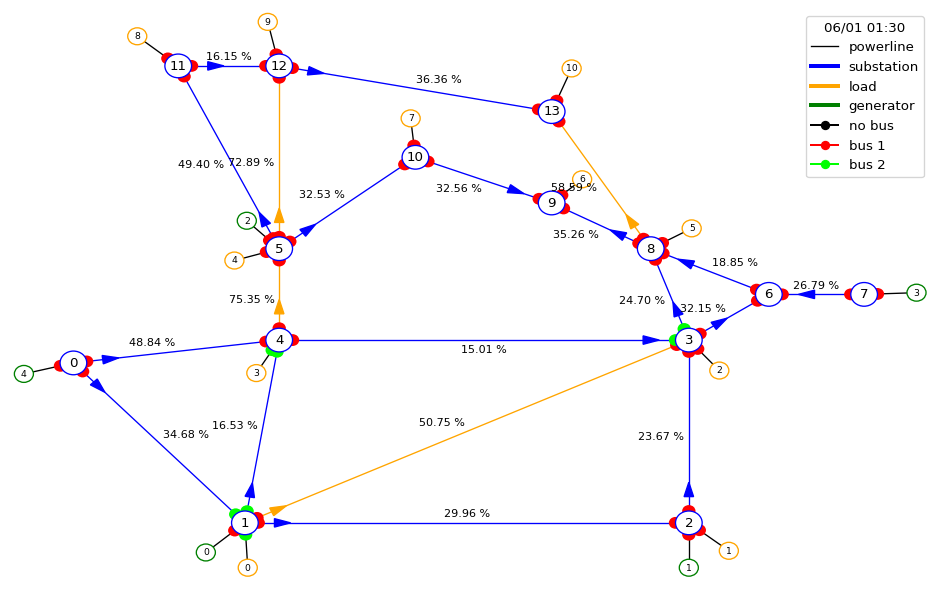

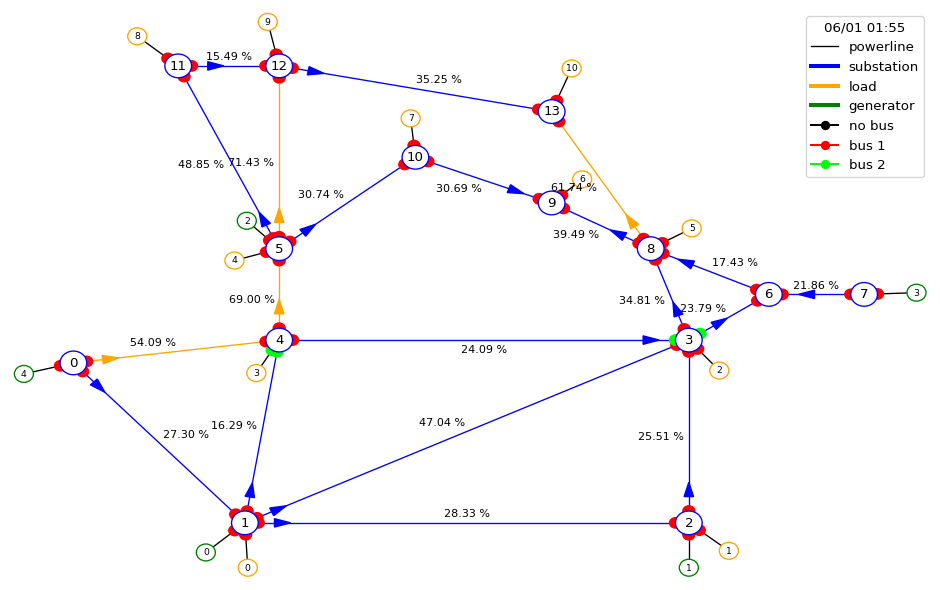

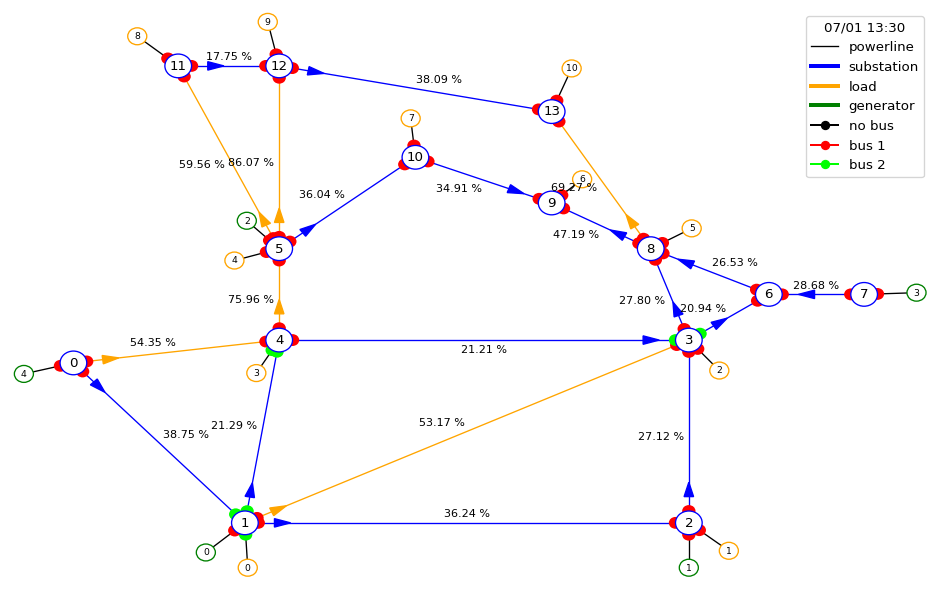

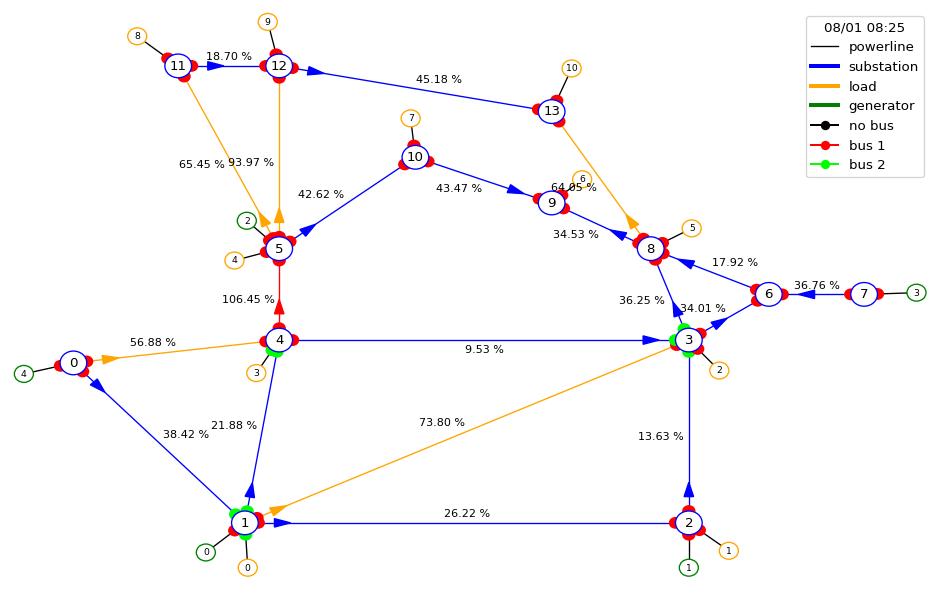

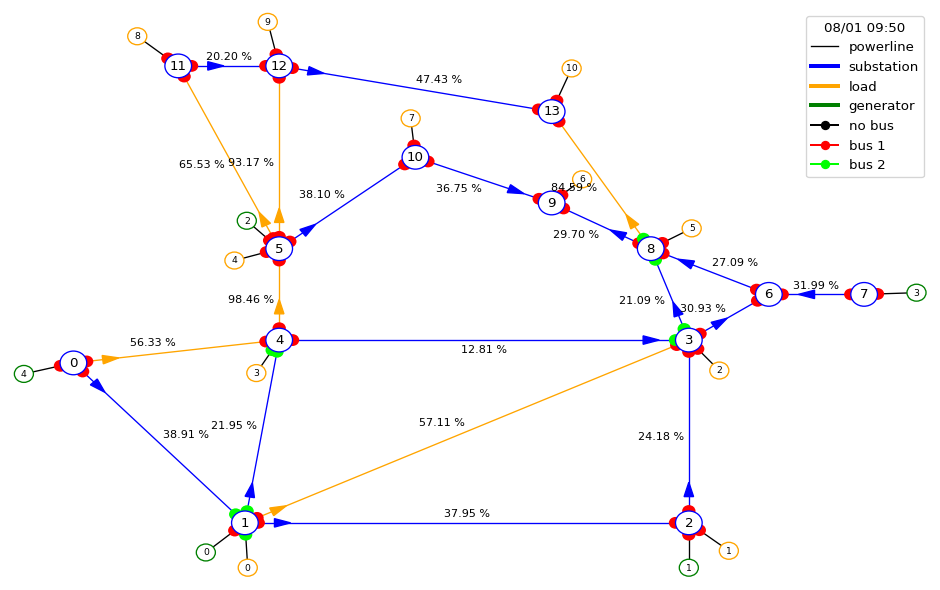

In [77]:
for state_num, state in agg_state_to_plot.items():
    
    # Justo to print the action (debug)
    state_ = env.action_space(state)
    print(state_)
    print()

    env.reset()
    # Find the time step where power flow converges
    ts = list(path.path.values).index([state_num])
    env.fast_forward_chronics(ts)
    obs, *_, info = env.step(env.action_space(state))
    
    print(info['exception'])
    fig_obs = plot_helper.plot_obs(obs, load_info=None, gen_info=None)

# Compare the cumulated scores for some baselines
- Do Nothing in Ref Topo
- Do Nothing in the best Topoes
- Best path with only one action at each timestep
- Best path with all actions possible

In [ ]:
#print('max reward by doin:')
#nx.dag_longest_path_length(G)
print('min score by doing:')
nx.bellman_ford_path_length(G,'init','end')

In [ ]:
sumDoNothinginRef=rewards_scenario.iloc[:, -1].sum()
#print('max reward by doing nothing in reference configuration:')
print('score by doing nothing in reference configuration:')
print(sumDoNothinginRef)

In [ ]:
sums=rewards_scenario[rewardActionColumns].sum()#.iloc[:,2:ncolumns].sum()
sumDoNothinginBest=sums.min()#sums.max()

print('max reward by doing nothing in a configuration:')
print(rewardActionColumns[sums.argmin()])#print(sums.argmax())
print(sumDoNothinginBest)

In [ ]:
sumBest=rewards_scenario[rewardActionColumns].min(axis=1).sum()#max(axis=1).sum()
print('max reward by doing the best configuration with all actions possible:')
sumBest

In [ ]:
plot2=rewards_scenario[rewardActionColumns].sum().plot.hist()

In [ ]:
idxActions=[17,25,41,56,57,72,88,585,601,617,826,56,650]
actions.iloc[idxActions]

In [ ]:
actions.iloc[5832]